# Week 11 Homework (9)

# Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it 
4. Describe how to use this to create arbitrary multivariate GLM regressions

In [23]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats import expon, multivariate_normal, norm, beta, lognorm
import seaborn

In [56]:
# Load the dataset
data = pd.read_csv('song_data.csv').dropna()

# Display the first few rows of the dataframe to understand its structure
data.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [57]:
# List of numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Use IQR to treat outliers if the normality is not fulfilled so that z-score method cannot be used
# Calculate IQR for each numerical column and determine outlier boundaries
Q1 = data[numerical_cols].quantile(0.01)
Q99 = data[numerical_cols].quantile(0.99)
IQR = Q99 - Q1

# Determine outlier boundaries
lower_bound = Q1
upper_bound = Q99

# Identify outliers
outliers = (data[numerical_cols] < lower_bound) | (data[numerical_cols] > upper_bound)

# Remove outliers from the dataset
data = data[~outliers.any(axis=1)]
data.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [58]:
# Randomly select 500 indices from the dataset
random_indices = np.random.choice(data.shape[0], 500, replace=False)

# Subset X and y based on the selected indices
data = data.iloc[random_indices]

# Normalize/Scale Data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[numerical_cols]), columns=numerical_cols)

# Combine scaled numerical data with non-numerical data
data_final = pd.concat([data.drop(columns=numerical_cols).reset_index(drop=True), data_scaled], axis=1)

data_final.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Gole Sang,0.326316,0.786755,0.643778,0.147493,0.498707,0.000010,0.363636,0.051530,0.513794,0.0,0.030670,0.427060,0.5,0.361796
1,Like Juve (Juventus),0.442105,0.270333,0.156532,0.235988,0.983140,0.000009,0.181818,0.105548,0.760168,1.0,1.000000,0.570101,0.5,0.562060
2,Hold Us Together,0.000000,0.367576,0.027248,0.294985,0.817916,0.000000,0.000000,0.133363,0.804913,1.0,0.082026,0.612682,0.5,0.449824
3,Jolene,0.800000,0.147753,0.579289,0.629794,0.508823,0.000000,0.090909,0.131899,0.458372,0.0,0.023538,0.327169,0.5,0.828345
4,Heroine,0.715789,0.270800,0.061232,0.625369,0.784197,0.000002,0.636364,0.515444,0.894032,1.0,0.032810,0.421355,0.5,0.578565


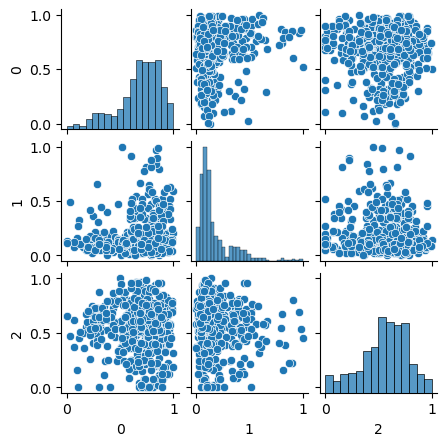

In [59]:
variables_of_interest = ["loudness", "liveness", "song_popularity"]

data_array = data_final[variables_of_interest].values

seaborn.pairplot(pd.DataFrame(data_array),height=1.5);

In [60]:
loudness = data_final['loudness'].values
liveness = data_final['liveness'].values
popularity = data_final['song_popularity'].values

In [61]:
# 1. Fit each variable separately with a suitable distribution.
# LOUDNESS as Beta
loudness_nonzero = np.clip(loudness, 1e-6, 1 - 1e-6)
loudness_params = beta.fit(loudness_nonzero, floc=0, fscale=1)

# LIVENESS as Beta
liveness_nonzero = np.clip(liveness, 1e-6, 1 - 1e-6)
liveness_params = beta.fit(liveness_nonzero, floc=0, fscale=1)

# SONG POPULARITY as Beta
popularity_nonzero = np.clip(popularity, 1e-6, 1 - 1e-6)
popularity_params = beta.fit(popularity_nonzero, floc=0, fscale=1)

# 2. Convert each variable’s raw data to Uniform(0,1) via that distribution’s CDF.
u_loudness = beta.cdf(loudness, *loudness_params)
u_liveness = beta.cdf(liveness, *liveness_params)
u_pop      = beta.cdf(popularity, *popularity_params)
u_loudness = np.clip(u_loudness, 1e-6, 1 - 1e-6)
u_liveness = np.clip(u_liveness, 1e-6, 1 - 1e-6)
u_pop      = np.clip(u_pop,      1e-6, 1 - 1e-6)

# 3. Map Uniform(0,1) → standard Normal space using the probit transform.
z_loudness = norm.ppf(u_loudness)
z_liveness = norm.ppf(u_liveness)
z_pop      = norm.ppf(u_pop)

# Stack them into a single (N x 3) array for the Gaussian copula step:
Z = np.column_stack([z_loudness, z_liveness, z_pop])

In [68]:
with pm.Model() as copula_model:
    L, R, stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0),
                                   compute_corr=True)

    mvn = pm.MvNormal("copula_obs", mu=np.zeros(3), chol=L, observed=Z)

    idata = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.


array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'R'}>]],
      dtype=object)

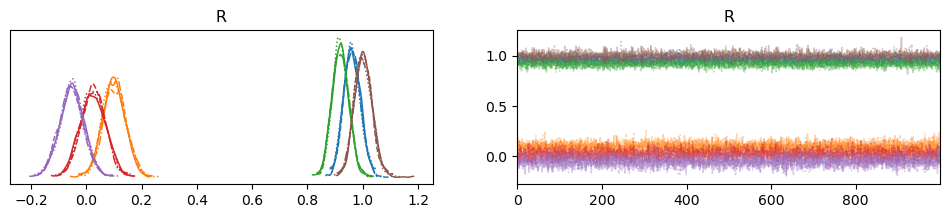

In [73]:
az.plot_trace(idata, var_names=["R"])

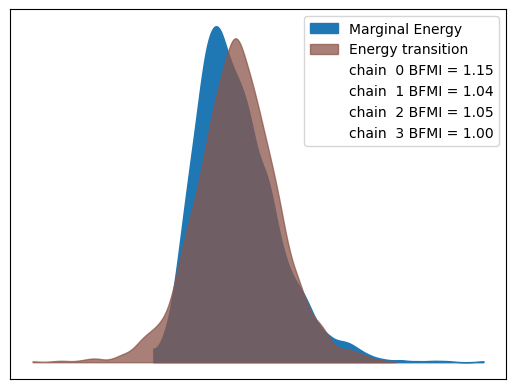

In [71]:
az.plot_energy(idata);

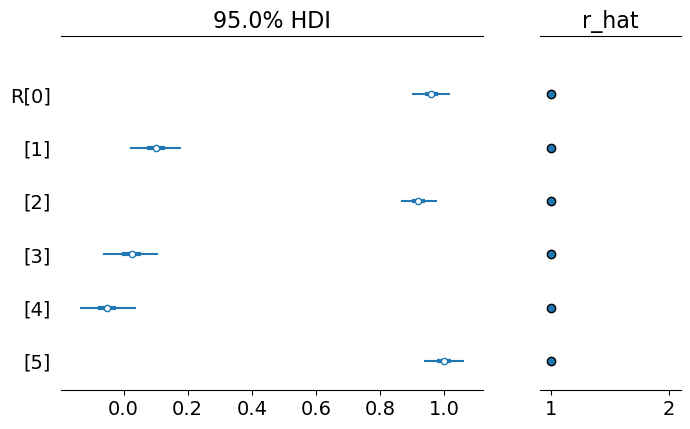

In [72]:
az.plot_forest(idata, var_names=["R"], 
               combined=True, hdi_prob=0.95, r_hat=True);

All diagnostics—trace plots, BFMI, and \\(\hat{R}\\) statistics—point toward excellent convergence and robust inference. The posterior intervals are well-defined, indicating that the model parameters are estimated with precision. These outcomes collectively suggest that our Bayesian model has been properly specified and that the Markov chains are sampling efficiently.

Therefore, we can be confident in interpreting the estimated effects and making further inferences about the relationships captured by this model.

## Q1 (3)
### What is a Copula?

In general terms, a **copula** is a mathematical function that describes how multiple random variables are “coupled” through their joint dependence structure, separately from each variable’s marginal distribution. The idea is that each variable is first converted to a uniform scale \\([0,1]\\) via its own CDF, and then those \\([0,1]\\) values are mapped (often via the normal quantile function) to some latent space in which we fit a correlation (or covariance) structure. This correlation structure is the “copula” that ties the variables together, independently of their individual marginal shapes.

---

### Two Versions of the Copula Code

#### 1) **Two-Pass (Marginals + Copula) Approach**  
The **first version** (the so-called two-pass approach) does the following steps:

1. **Fit Marginals (Pass 1)**  
   Each variable is fit separately to a chosen distribution (e.g., Beta, Gamma, Lognormal, etc.) to capture the correct shape and support of each variable.  
2. **Transform to Uniform(0,1)**  
   For each observation, we compute the CDF value under that fitted marginal, giving a number in \\([0,1]\\).  
3. **Map Uniform → Latent Normal**  
   Apply the Normal inverse CDF (the probit transform) to get a latent normal value.  
4. **Estimate Correlation (Pass 2)**  
   Finally, we feed these latent-normal data into a multivariate-normal likelihood (using, e.g., `LKJCholeskyCov`) to estimate the correlation matrix.  
   
#### 2) **The Second (“Single‐Pass”) Version**

In the second version, the **copula idea is implemented inside one single PyMC model** rather than in two separate passes.  Each observed variable’s marginal is declared within the model (e.g., Gamma, Exponential, Chi‐square), and at the same time we transform each observation from its raw scale into uniform space by applying the log‐CDF and exponentiation. Then we map those uniform values to a latent normal space via the probit (or `Normal.icdf`) transform. Finally, a multivariate normal likelihood with an LKJ prior on its correlation matrix enforces the copula structure among the latent variables.

**Summary of Steps in One Pass**:

1. **Declare Marginals**: For each variable \\(Y_i\\), pick a distribution (Gamma, Exponential, etc.).  
2. **Transform to Uniform(0,1)**: Within the model, compute \\(\exp(\logcdf(Y_i))\\).  
3. **Transform to Latent Normal**: Apply `Normal.icdf(...)` to those uniform values, obtaining a latent normal variable \\(Z_i\\).  
4. **Correlation Structure**: Place an LKJ prior on the correlation matrix \\(R\\).  
5. **Potential**: Add a log‐likelihood term that says \\((Z_1, Z_2, \ldots)\\) are drawn from `MvNormal(..., cov=R)`.  

Because all these steps happen in one unified model, PyMC’s sampler infers the marginal parameters **and** the correlation matrix simultaneously. This “single‐pass” approach can more naturally capture posterior uncertainty in both the margins and the dependence structure. 

   

## Q1 (4)

### Creating a Multivariate GLM with Two Outcomes: “song popularity” and “danceability,” and Predictors: “loudness,” “liveness,” “tempo”

#### 1. Specify the Marginal Distributions and Link Functions for Each Outcome

1. **Song Popularity**  
   - If *song popularity* is a continuous measure on \\([0,1]\\), you might choose a **Beta** distribution with, for example, a *logit* link.  
   - Then the expected popularity for each track \\(i\\) is \\(\mu_{i,\text{pop}}\\), connected to the linear predictor by  
     \\[
       \text{logit}(\mu_{i,\text{pop}}) 
       \;=\; \beta_{0,\text{pop}} \;+\; \beta_{\text{loudness},\text{pop}}\cdot \text{loudness}_i
       \;+\; \beta_{\text{liveness},\text{pop}}\cdot \text{liveness}_i
       \;+\; \beta_{\text{tempo},\text{pop}}\cdot \text{tempo}_i.
     \\]  
   - In a Bayesian model, you would place priors on each of these \\(\beta\\) coefficients as well as on the Beta distribution’s precision or dispersion parameter.

2. **Danceability**  
   - Suppose *danceability* is also on \\([0,1]\\). You might pick another Beta distribution (possibly with its own link function). Or, if it is an unbounded real in practice, you might choose a **Normal** distribution with identity link, etc.  
   - As an example, if it is Beta with logit link, you do similarly:  
     \\[
       \text{logit}(\mu_{i,\text{dance}}) 
       \;=\; \beta_{0,\text{dance}} \;+\; \beta_{\text{loudness},\text{dance}}\cdot \text{loudness}_i
       \;+\; \beta_{\text{liveness},\text{dance}}\cdot \text{liveness}_i
       \;+\; \beta_{\text{tempo},\text{dance}}\cdot \text{tempo}_i.
     \\]

Hence, for each outcome \\(\{ \text{popularity}, \text{danceability}\}\\), you define its own link and linear predictor involving the same (or possibly different) predictors.

---

#### 2. Account for Correlation Between Outcomes

Because we have **two outcome variables** we suspect might be correlated (popularity might relate to danceability), we want a **multivariate** approach. There are two major strategies:

1. **Multivariate Likelihood Directly**  
   - If both outcomes share the same type of distribution (e.g., both are *unbounded real*), you might specify them jointly in a **multivariate normal** with correlated errors.  
   - However, if each outcome has a different distribution (like Beta or other non‐Gaussian families), you often can’t just do a standard “multivariate normal” likelihood.

2. **Copula**  
   - For instance, a **Gaussian Copula** approach:  
     1. You define each outcome’s marginal distribution (Beta for popularity, Beta for danceability).  
     2. You transform each observed value to a uniform \\([0,1]\\) scale by the marginal’s CDF.  
     3. You map those uniforms to a latent normal domain (probit transform).  
     4. Impose a correlation structure among these latent normal variables (like an LKJ prior on a 2×2 correlation matrix).  

This copula method effectively separates each outcome’s “marginal shape” from their joint dependence, letting them be correlated even if each marginal is Beta or something else.

---

#### 3. Build the Full Model

Putting it all together:

1. **Marginal GLMs** (One for Popularity, One for Danceability)  
   - Each outcome has a linear predictor using \\(\text{loudness}\\), \\(\text{liveness}\\), and \\(\text{tempo}\\).  
   - Each has a chosen distribution (both Beta, or Beta + Normal, or etc.) plus relevant link functions.  
   - That yields two sets of regression coefficients: \\(\{\beta_{\cdot,\text{pop}}\}\\) and \\(\{\beta_{\cdot,\text{dance}}\}\\).

2. **(If Using a Copula)**  
   - Convert each outcome’s observed data to a \\([0,1]\\) quantile by the Beta (or chosen) distribution’s CDF.  
   - Convert each quantile to latent normal.  
   - Place a correlation prior on these two latent normals so that we can learn how popularity co‐varies with danceability *beyond* what their predictors explain.

3. **Sampling**  
   - In a Bayesian framework, you place priors on the regression coefficients, on the (co)variance or correlation structure, and on any additional hyperparameters.  
   - You run MCMC or variational inference to obtain posterior samples of everything.  

---

#### 4. Interpret the Results

- **Coefficients**: From each GLM, you see how \\(\text{loudness}\\), \\(\text{liveness}\\), and \\(\text{tempo}\\) shape either popularity or danceability. For instance, \\(\beta_{\text{loudness},\text{pop}} > 0\\) might mean louder tracks tend to have higher popularity on average.  
- **Correlation**: The copula (or the multivariate error term) shows whether popularity and danceability are positively or negatively correlated *once you control for the predictors.*  
- **Prediction**: You can make predictions for each outcome variable given new predictor values, and, because it is a **multivariate** approach, you can also simulate how the two outcomes co‐vary.

---

#### 5. Summary

Thus, to set up a **multivariate GLM** for “song popularity” and “danceability” with “loudness,” “liveness,” and “tempo” as predictors, you:

1. Pick a **marginal** distribution (e.g., Beta) and link (logit, etc.) for each outcome.  
2. Write down each outcome’s **linear predictor** in terms of \\(\text{loudness}\\), \\(\text{liveness}\\), \\(\text{tempo}\\).  
3. (Optionally) Use a **copula** to capture correlation between these two different marginal distributions.  
4. Fit all parameters (regression coefficients, correlation parameters, etc.) in one Bayesian model or in a two‐step procedure.

In this way, you get a joint model that captures each outcome’s distinct shape (Beta or otherwise) *and* the dependence that remains after controlling for your predictor variables.

In [ ]:
# Below are code for single-pass

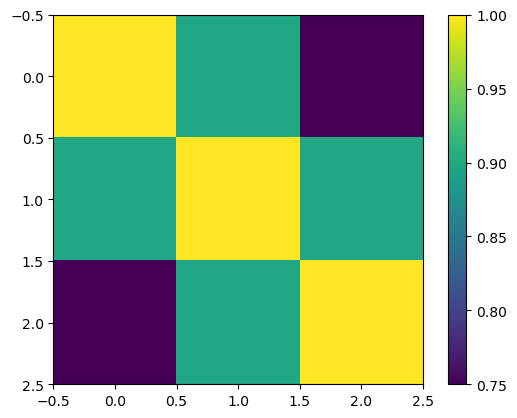

In [89]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


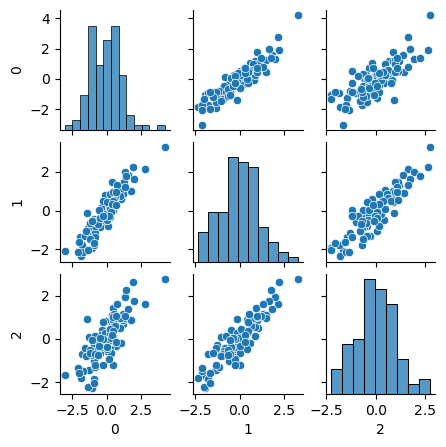

In [90]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

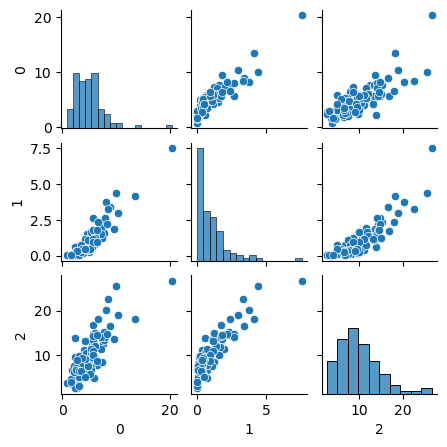

In [91]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

In [129]:
import pymc as pm
import arviz as az

with pm.Model() as copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
    y0_ = pm.Deterministic('y0_', 
            pm.Normal.icdf(
               pm.math.exp(pm.Gamma.logcdf(y0, alpha=p0, inv_beta=1)), 
                           mu=0, sigma=1))
    
    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
    y1_ = pm.Deterministic('y1_', 
            pm.Normal.icdf(
               pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)), 
                           mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_', 
            pm.Normal.icdf(
               pm.math.exp(pm.ChiSquared.logcdf(y2, nu=p2)), 
                           mu=0, sigma=1))
    
    L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=3), 
                                 compute_corr=True)
    
    potential = pm.Potential("MVNeval", 
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                             pm.math.concatenate([y0_,y1_,y2_], axis=1)))
    
    idata = pm.sample()

# This probally produces a lot of warnings but it will run and provide inference


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p0, p1, p2, R]


/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not

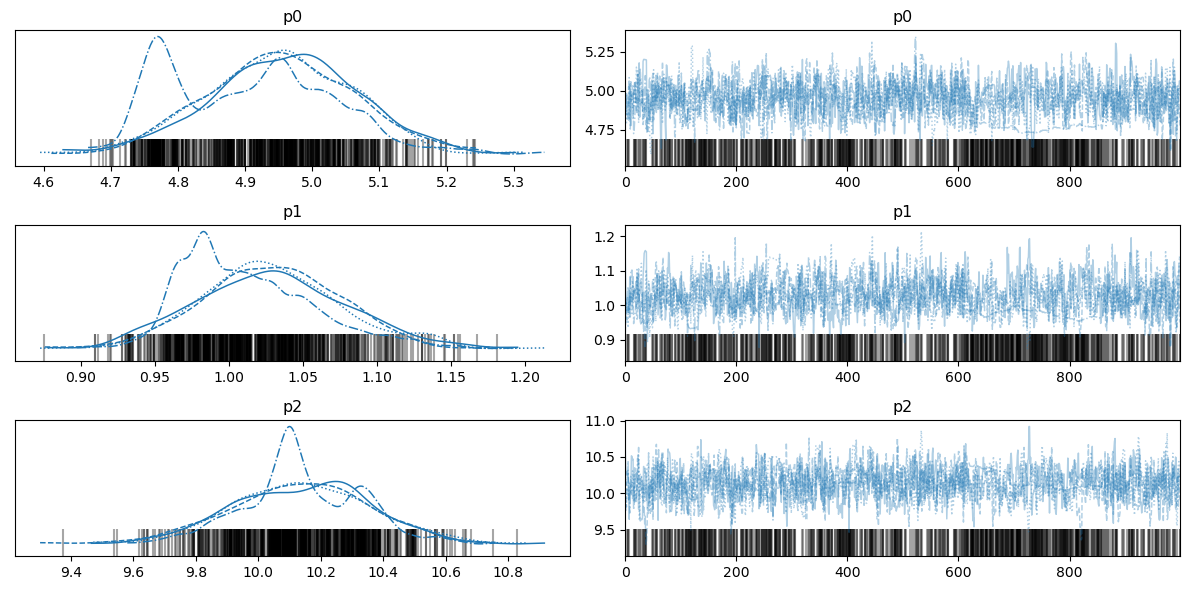

In [134]:
# Estimation is essentially correct
az.plot_trace(idata, var_names=['p0','p1','p2'])
plt.tight_layout()

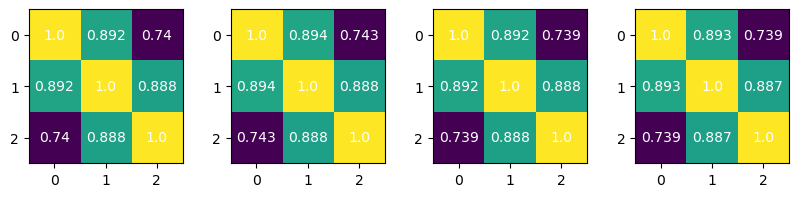

In [154]:
# Estimation is essentially correct
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(idata.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)), 
                       color='w', va='center', ha='center')

## Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



In [79]:
variables_of_interest = ["loudness", "liveness", "tempo"]
X = data_final[["loudness", "liveness", "tempo"]].values
y = data_final[["song_popularity", "danceability"]].values
m = y.shape[1] 
p = X.shape[1]
n = X.shape[0]
p, n, m

(3, 500, 2)

In [80]:
# ------------------------------------------------------------------------------
# 1) SPIKE-AND-SLAB MULTIVARIATE MODEL
# ------------------------------------------------------------------------------
with pm.Model() as spike_slab_model:

    # For correlation among the 2 outcome dimensions, we can use an LKJ prior for
    # the covariance of a 2D multivariate normal.
    L, corr, stds = pm.LKJCholeskyCov(
        "cov_chol", n=m, eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True
    )
    
    # We'll have an intercept for each outcome dimension (shape=(m,))
    intercept = pm.Normal("intercept", mu=0, sigma=5, shape=m)

    # Define spike-and-slab hyperpriors for each predictor in each outcome dimension.
    #   gamma_ij in {0,1} says "include predictor i in dimension j".
    #   slab_ij ~ Normal(0, tau_slab) is the "slab" distribution.
    #   Then coeff_ij = gamma_ij * slab_ij.
    pi = pm.Beta("pi", alpha=2, beta=2)           # prior fraction of included terms
    tau_slab = pm.HalfNormal("tau_slab", sigma=1) # scale for included terms

    gamma = pm.Bernoulli("gamma", p=pi, shape=(p, m))
    slab  = pm.Normal("slab", mu=0, sigma=tau_slab, shape=(p, m))
    coeff = pm.Deterministic("coeff", gamma * slab)

    # For each observation, the mean of Y is: (X dot coeff) + intercept
    # We do it in vector form: X has shape (n, p), coeff has shape (p, m),
    # so mu has shape (n, m).
    mu = pm.math.dot(X, coeff) + intercept

    # Observed Y is an n x m, so we specify a MvNormal with dimension=2 for each row
    # We use 'chol=L' for the 2x2 covariance. Observed data has shape (n,m).
    # By default, pm.MvNormal expects shape (n,m), so this is valid:
    Y_obs = pm.MvNormal(
        "Y_obs",
        mu=mu,
        chol=L,           # the Cholesky factor from LKJ
        observed=y
    )

    # MCMC sampling
    idata1 = pm.sample(
        draws=1000, tune=1000, chains=2, random_seed=42, 
        target_accept=0.9
    )

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [cov_chol, intercept, pi, tau_slab, slab]
>BinaryGibbsMetropolis: [gamma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 262 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [93]:
az.summary(idata1, var_names=['coeff'], round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"coeff[0, 0]",0.00965,0.02959,-0.03221,0.08859,0.00135,0.00178,622.59309,783.64914,1.00175
"coeff[0, 1]",0.18897,0.04507,0.11164,0.28220,0.00136,0.00125,1094.34463,1094.61615,1.00330
"coeff[1, 0]",-0.05545,0.06307,-0.18677,0.00022,0.00324,0.00111,425.66387,1408.25810,1.00607
"coeff[1, 1]",-0.06389,0.06237,-0.17993,0.00000,0.00348,0.00089,368.52949,1460.75624,1.01310
"coeff[2, 0]",-0.01546,0.03347,-0.09964,0.02133,0.00170,0.00146,458.96368,960.64925,1.01076
"coeff[2, 1]",-0.18693,0.04294,-0.26271,-0.10175,0.00103,0.00089,1749.36903,1505.15099,0.99979


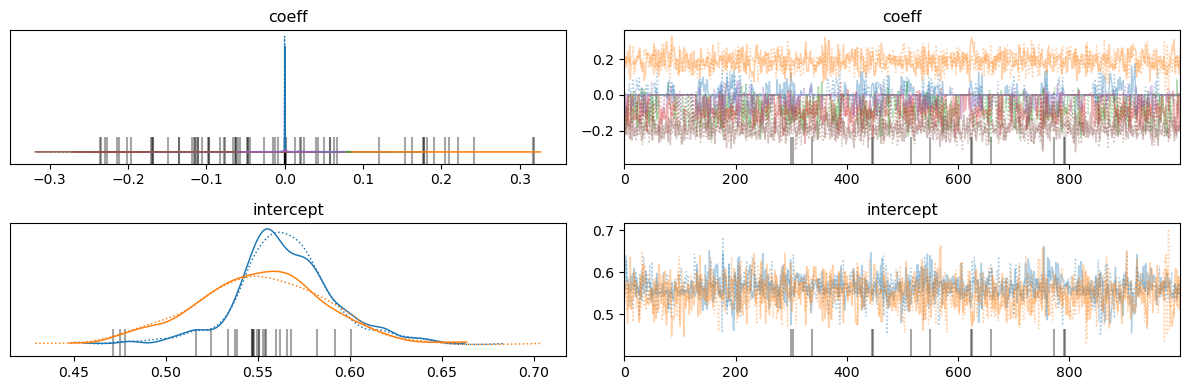

In [89]:
az.plot_trace(idata1, var_names=["coeff", "intercept"])
plt.tight_layout()
plt.show()

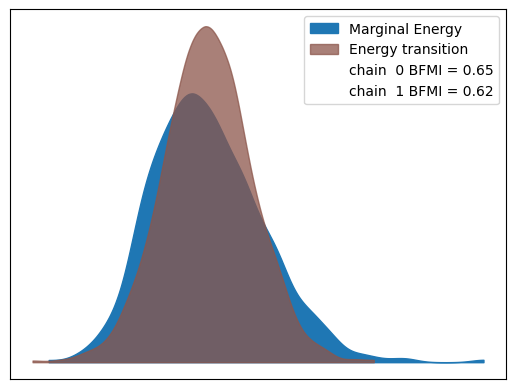

In [90]:
az.plot_energy(idata1);

Sampling: [Y_obs]


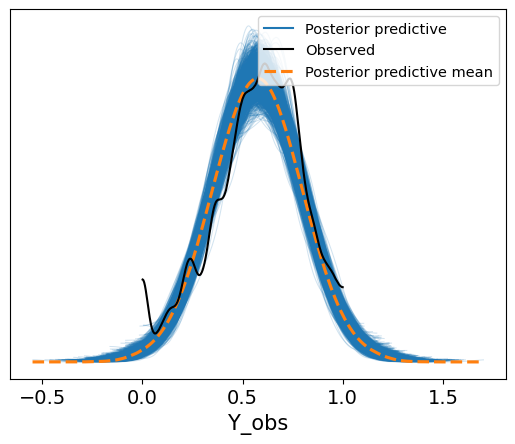

In [92]:
with spike_slab_model:
    ppc = pm.sample_posterior_predictive(idata1, random_seed=42)

az.plot_ppc(ppc)
plt.show()

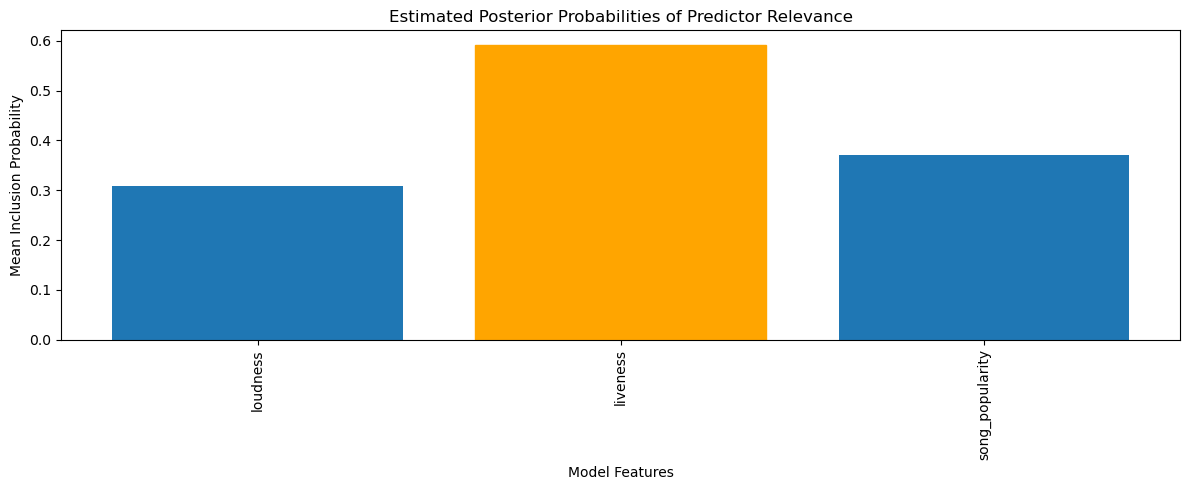

In [100]:
# Compute average posterior inclusion probabilities
avg_probs = idata1.posterior['gamma'].mean(dim=('chain', 'draw')).values

# Define cutoff value
cutoff = 0.5  
key_predictors_mask = avg_probs[:, 0] > cutoff
key_predictors = [pred for idx, pred in enumerate(variables_of_interest) if key_predictors_mask[idx]]

# Plotting
plt.figure(figsize=(12, 5))
bar_container = plt.bar(range(len(avg_probs[:, 0])), avg_probs[:, 0])
plt.title("Estimated Posterior Probabilities of Predictor Relevance")
plt.xlabel("Model Features")
plt.ylabel("Mean Inclusion Probability")

plt.xticks(ticks=range(len(variables_of_interest)), labels=variables_of_interest, rotation=90)

# Emphasize selected predictors
for idx, bar in enumerate(bar_container):
    if key_predictors_mask[idx]:
        bar.set_color('orange')

plt.tight_layout()
plt.show()

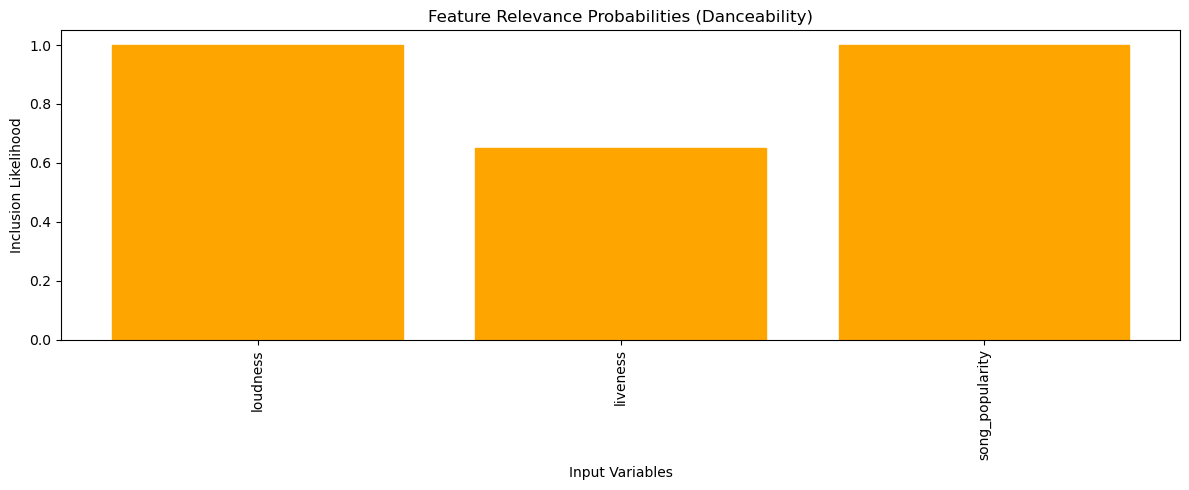

In [101]:
# Identify key features for second target
relevant_mask = avg_probs[:, 1] > cutoff
relevant_features = [feat for i, feat in enumerate(variables_of_interest) if relevant_mask[i]]

# Visualization
plt.figure(figsize=(12, 5))
bar_plot = plt.bar(range(len(avg_probs[:, 1])), avg_probs[:, 1])
plt.title("Feature Relevance Probabilities (Danceability)")
plt.xlabel("Input Variables")
plt.ylabel("Inclusion Likelihood")

plt.xticks(ticks=range(len(variables_of_interest)), labels=variables_of_interest, rotation=90)

# Highlight influential features
for i, bar in enumerate(bar_plot):
    if relevant_mask[i]:
        bar.set_color('orange')

plt.tight_layout()
plt.show()

## Variable Selection Analysis
The visualizations above present posterior inclusion probabilities for predictor relevance across two outcome variables: song popularity and danceability. These probabilities are derived from Bayesian variable selection using spike-and-slab priors, with a threshold of 0.5 to identify key predictors.

In the first bar plot, which pertains to song popularity, only one predictor—liveness—exceeds the 0.5 inclusion threshold and is therefore highlighted in orange. This suggests that liveness is the most relevant feature in predicting song popularity among the candidate variables. Both loudness and song_popularity (as an input variable) show lower inclusion probabilities and are not identified as key predictors in this model.

In contrast, the second bar plot focuses on danceability as the target variable. Here, three variables—loudness, liveness, and song_popularity—all exceed the 0.5 threshold, indicating strong relevance for predicting danceability. The inclusion probabilities for loudness and song_popularity are especially high, approaching 1.0, which reflects strong posterior support for their importance in explaining variability in danceability scores.

Overall, the results suggest that the predictors' importance is target-dependent. While liveness is consistently important across both outcomes, loudness and song_popularity play more substantial roles in modeling danceability than in predicting song popularity. These findings highlight the nuanced nature of feature relevance in multivariate outcome modeling.

In [94]:
# ------------------------------------------------------------------------------
# 2) DIFFUSE NORMAL PRIOR MULTIVARIATE MODEL
# ------------------------------------------------------------------------------
with pm.Model() as normal_model:
    
    L2, corr2, stds2 = pm.LKJCholeskyCov(
        "cov_chol2", n=m, eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True
    )
    
    intercept2 = pm.Normal("intercept2", mu=0, sigma=5, shape=m)
    
    # Now each coefficient just has a wide normal prior:
    # shape=(p, m) for p=3, m=2
    # e.g. sigma=10 means minimal shrinkage:
    coeff2 = pm.Normal("coeff2", mu=0, sigma=10, shape=(p, m))
    
    mu2 = pm.math.dot(X, coeff2) + intercept2
    Y_obs2 = pm.MvNormal(
        "Y_obs2",
        mu=mu2,
        chol=L2,
        observed=y
    )
    
    idata2 = pm.sample(
        draws=1000, tune=1000, chains=2, random_seed=42, 
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [cov_chol2, intercept2, coeff2]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 124 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [96]:
az.summary(idata2, var_names=['coeff2'], round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"coeff2[0, 0]",0.04469,0.04688,-0.03877,0.13509,0.00115,0.00090,1640.02702,1482.98721,1.00310
"coeff2[0, 1]",0.20848,0.04437,0.12627,0.29105,0.00117,0.00112,1443.09936,1185.68127,1.00004
"coeff2[1, 0]",-0.11135,0.05492,-0.20859,-0.00248,0.00110,0.00106,2462.83044,1746.10226,1.00087
"coeff2[1, 1]",-0.11064,0.05280,-0.20352,-0.01046,0.00111,0.00115,2268.06912,1453.92274,1.00226
"coeff2[2, 0]",-0.04777,0.04501,-0.12975,0.03469,0.00099,0.00098,2095.37923,1279.00547,1.00047
"coeff2[2, 1]",-0.20078,0.04153,-0.27847,-0.12745,0.00083,0.00087,2517.84604,1703.89613,1.00118


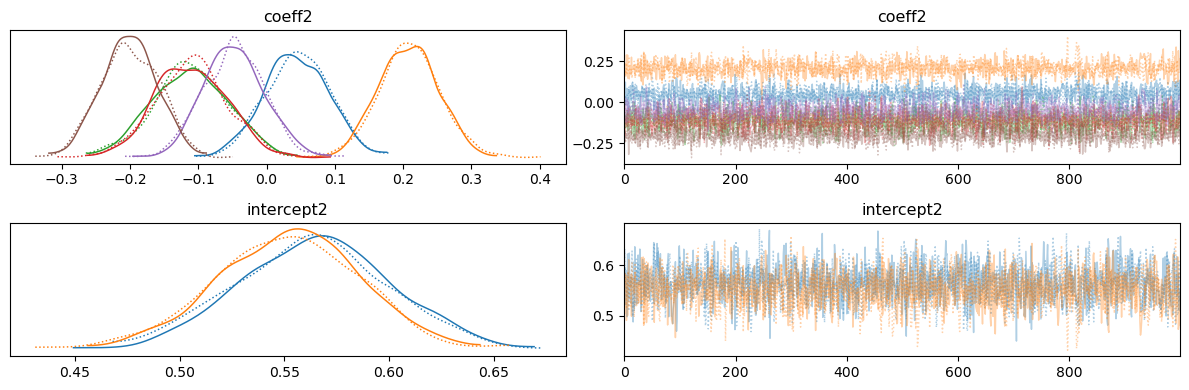

In [97]:
az.plot_trace(idata2, var_names=["coeff2", "intercept2"])
plt.tight_layout()
plt.show()

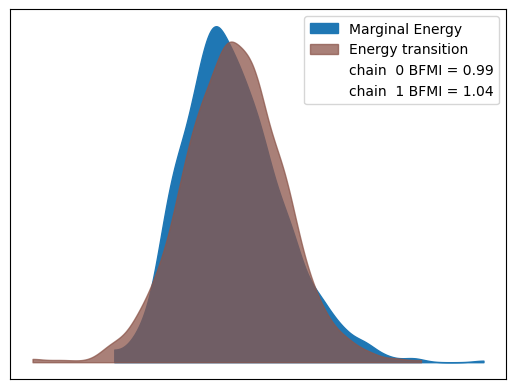

In [98]:
az.plot_energy(idata2);

Sampling: [Y_obs2]


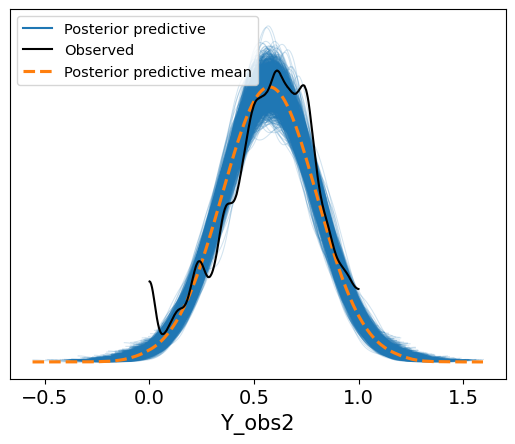

In [99]:
with normal_model:
    ppc = pm.sample_posterior_predictive(idata2, random_seed=42)

az.plot_ppc(ppc)
plt.show()

## Bayesian Model Diagnostics and Comparison
This section presents the diagnostics and inference comparison between two Bayesian models: the Spike and Slab model and the Diffuse Normal model. The results include posterior summaries, trace plots, energy diagnostics, and posterior predictive checks for each model.

### Spike and Slab Model Diagnostics
Posterior Summary and Trace Plots
The posterior summary table for the coeff variable shows that most coefficients are close to zero, with narrow highest density intervals (HDIs). This behavior is consistent with a sparsity-inducing prior like Spike and Slab, which allows for coefficients to shrink heavily toward zero.

The trace plots indicate reasonable convergence and mixing. The posterior density of the coeff variable is sharply peaked around zero, again reflecting the regularization effect of the spike prior. The intercept shows a smoother distribution and consistent mixing across chains, without any signs of divergence.

#### Energy and BFMI Diagnostics
The energy diagnostic plot shows some separation between the marginal energy and energy transition densities, and the reported Bayesian Fraction of Missing Information (BFMI) values for the chains are 0.65 and 0.62. These are above the minimum acceptable threshold of 0.3 but lower than ideal, suggesting that the sampler may be experiencing slightly inefficient exploration of the posterior energy landscape.

#### Posterior Predictive Check
The posterior predictive check (PPC) plot shows that the posterior predictive distribution closely follows the observed data. The black line (observed data) lies well within the blue bands (posterior predictive samples), and the dashed orange line (posterior predictive mean) tracks the observed pattern well. This indicates that the model fits the data adequately despite its sparsity assumptions.

### Diffuse Normal Model Diagnostics
Posterior Summary and Trace Plots
The summary statistics for the coeff2 variable indicate a wider spread in the posterior means and HDIs compared to the Spike and Slab model. Some coefficients are further from zero, suggesting less shrinkage and a more diffuse estimate of parameter effects.

The trace plots show good mixing and stability across chains. The posterior densities are more spread out and smooth compared to the spike-like behavior seen in the first model. The intercept also shows strong convergence behavior with overlapping chains and a well-behaved posterior shape.

#### Energy and BFMI Diagnostics
The energy plot for this model shows a strong overlap between marginal and transition energy distributions, indicating efficient exploration. BFMI values are close to or above 1.0, suggesting that the Hamiltonian Monte Carlo sampler is operating effectively and efficiently.

#### Posterior Predictive Check
The posterior predictive check again shows excellent coverage of the observed data. The blue posterior predictive bands encompass the black observed line across the entire range, and the orange dashed line follows the data closely. This confirms a strong model fit under more flexible priors.

### Model Comparison and Interpretation
Coefficient Shrinkage: The Spike and Slab model aggressively shrinks coefficients toward zero, making it useful for variable selection or sparsity-inducing tasks. In contrast, the Diffuse Normal model allows more flexibility and spreads the posterior more broadly, potentially identifying additional non-zero effects.

Sampler Efficiency: The Diffuse Normal model demonstrates better energy diagnostics (higher BFMI, more overlapping energy distributions), suggesting more efficient posterior exploration. The Spike and Slab model's slightly lower BFMI implies some room for improvement in sampler efficiency.

Predictive Accuracy: Both models produce satisfactory posterior predictive fits to the observed data. However, the Diffuse Normal model achieves this with a broader set of contributing predictors, while the Spike and Slab model does so with fewer active coefficients, reflecting its sparsity.

## Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations 

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



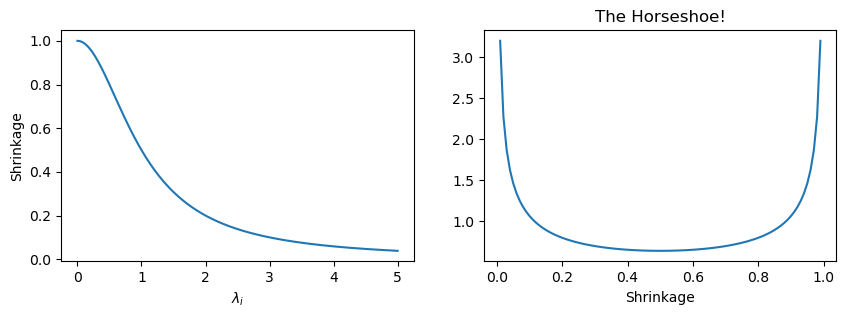

In [160]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$") 
# change of variables: 
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage, 
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) * 
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

In [104]:
with pm.Model() as hs_model:
    
    # [A] Error covariance for the 2 outcome variables:
    #    We'll use an LKJ prior with Exponential(1.0) on the std devs.
    L, corr, stds = pm.LKJCholeskyCov(
        "chol_cov", 
        n=m,           # dimension = 2 outcomes
        eta=2.0,       # shape parameter for correlation
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True
    )

    # [B] Global shrinkage parameter 'tau' (e.g. HalfStudentT).
    #     D0 is often an approximate guess at how many coefficients are "non-zero".
    D  = p*m  # total number of coefficients
    D0 = max(1, int(D/2))  # guess half might be non-trivial, for demonstration
    # Suppose 'sigma_Y' is a rough scale of Y; we use it as a stand-in for the "σ" in pictures
    sigma_Y = y.std()
    
    tau = pm.HalfStudentT(
        "tau", 
        nu=2, 
        sigma=(D0/(D - D0) * sigma_Y/np.sqrt(n))  # rule-of-thumb for scale
    )

    # [C] Local shrinkage parameters 'lambda_ij' ~ HalfStudentT
    #     shape=(p,m) because each predictor–outcome pair can have its own shrink factor.
    lam = pm.HalfStudentT("lam", nu=2, shape=(p, m))

    # [D] c² ~ InverseGamma(1,1), controlling how strong the local shrink is
    c2 = pm.InverseGamma("c2", alpha=1, beta=1)

    # [E] Latent standard normal draws 'z_ij' for reparameterization of each coefficient
    z = pm.Normal("z", mu=0, sigma=1, shape=(p, m))

    # [F] Combine them into actual regression coefficients:
    #     The formula from the references is:
    #         β_{i,j} = z_{i,j} * τ * λ_{i,j} * sqrt( c2 / [ c2 + τ² λ_{i,j}² ] )
    #     This ensures heavy‐tailed shrinkage for “irrelevant” coefficients.
    #     If you want to *omit* the ratio c2/(c2 + τ²λ²), that is a simpler version
    #     of the horseshoe as well.
    # For dimension convenience, we do elementwise ops:
    #   (All variables are shape (p,m), except scalars.)

    # The ratio term:
    ratio = c2 / (c2 + tau**2 * lam**2)
    # Now define beta
    beta = pm.Deterministic(
        "beta",
        z * tau * lam * pm.math.sqrt(ratio),
    )

    # [G] Intercept for each outcome dimension (optional prior)
    intercept = pm.Normal("intercept", mu=0, sigma=5, shape=m)

    # [H] Predicted means for the 2D outcome = (n x m)
    mu = pm.math.dot(X, beta) + intercept

    # [I] Observed data: a 2D MvNormal with Cholesky L
    y_obs = pm.MvNormal(
        "y_obs",
        mu=mu,
        chol=L,
        observed=y
    )

    # [J] Sample
    idata3 = pm.sample(
        draws=1000, tune=1000, chains=2, target_accept=0.9, random_seed=42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [chol_cov, tau, lam, c2, z, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 414 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [106]:
az.summary(idata3, var_names=['beta'], round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.01156,0.03123,-0.04288,0.07848,0.00094,0.00080,1093.29263,1466.88027,1.00074
"beta[0, 1]",0.16948,0.05187,0.07559,0.26905,0.00147,0.00140,1296.26105,896.07423,1.00059
"beta[1, 0]",-0.04652,0.04950,-0.14807,0.02508,0.00140,0.00090,1098.91154,1694.93766,1.00002
"beta[1, 1]",-0.04969,0.05067,-0.15055,0.02384,0.00157,0.00093,889.93387,1384.44197,0.99965
"beta[2, 0]",-0.01816,0.03182,-0.08920,0.03051,0.00078,0.00069,1598.63616,1826.38152,0.99997
"beta[2, 1]",-0.17206,0.04499,-0.25570,-0.08892,0.00107,0.00099,1804.70394,1038.08708,1.00128


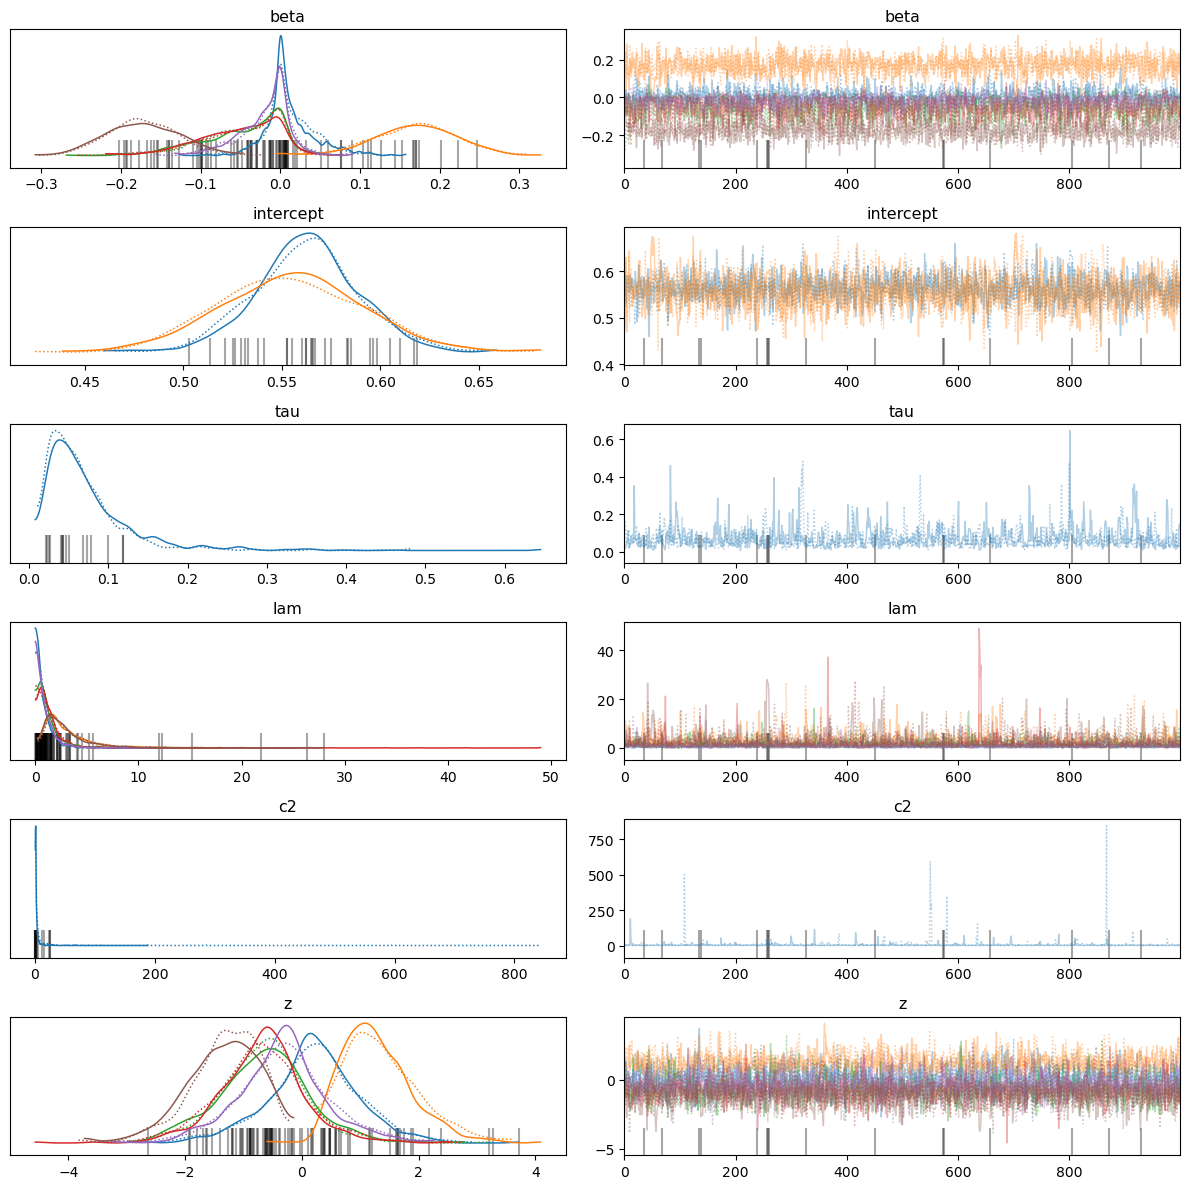

In [108]:
az.plot_trace(idata3, var_names=["beta", "intercept", "tau", "lam", "c2", "z"])
plt.tight_layout()
plt.show()

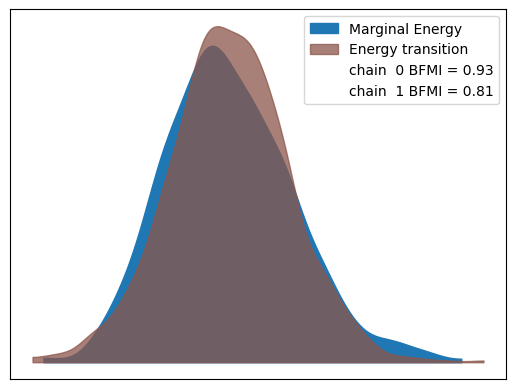

In [109]:
az.plot_energy(idata3);

Sampling: [y_obs]


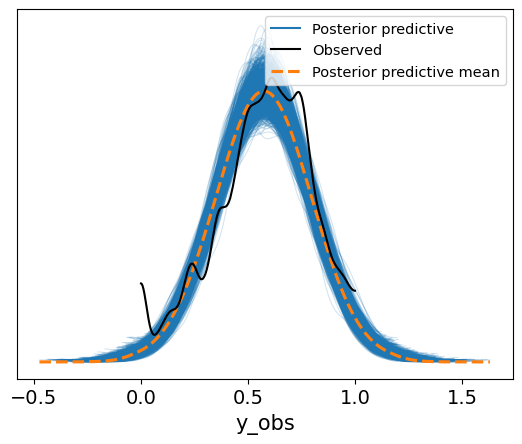

In [110]:
with hs_model:
    ppc = pm.sample_posterior_predictive(idata3, random_seed=42)

az.plot_ppc(ppc)
plt.show()

## Bayesian Diagnostics and Inference: Horseshoe Prior vs. Spike-and-Slab
### Diagnostics for the Horseshoe Prior Model
The posterior summary table for the beta coefficients reveals that several parameters have means near zero with relatively narrow highest density intervals (HDIs), consistent with the regularizing behavior of the horseshoe prior, which is designed for sparse regression. Notably, one coefficient (beta[0, 1]) stands out with a mean of approximately 0.17 and a 95% HDI that does not include zero, suggesting a strong and relevant effect.

The trace and density plots show well-behaved sampling across all parameters. The coefficients cluster tightly near zero, but with heavier tails than those seen in the spike-and-slab model. The chains exhibit good mixing and no visible signs of divergence. The additional parameters (tau, lam, c2, z) used for shrinkage and hierarchy in the horseshoe prior show variability consistent with global-local shrinkage behavior.

The energy plot supports efficient sampling. The Bayesian Fraction of Missing Information (BFMI) values are 0.93 and 0.81, both well above the minimum threshold of 0.3, indicating satisfactory Hamiltonian Monte Carlo performance and energy transition overlap.

The posterior predictive check (PPC) indicates a strong model fit. The blue posterior predictive samples cover the black observed line, and the dashed orange posterior mean closely follows the empirical trend. This suggests that the model generalizes well and accurately captures the data-generating process.

## Comparison to the Spike-and-Slab Model
Both the horseshoe prior and spike-and-slab models are designed to handle sparse signals, but they differ in their shrinkage behavior and posterior characteristics.

### Shrinkage Behavior:
The spike-and-slab prior enforces more discrete variable selection, leading to sharply peaked posterior densities at or near zero for many coefficients. In contrast, the horseshoe prior yields a more continuous shrinkage pattern with heavier tails, allowing for small but nonzero coefficients to survive regularization.

### Coefficient Interpretation:
The spike-and-slab model clearly distinguished active from inactive predictors with inclusion probabilities. The horseshoe prior identifies relevance by posterior means and credible intervals; beta[0, 1] is clearly relevant here, while others are effectively shrunk.

### Sampling Diagnostics:
Both models show well-mixed chains and good convergence statistics. However, the horseshoe model shows slightly more variability in shrinkage parameters (lam, tau, c2), which is expected due to its hierarchical structure.

### Posterior Predictive Performance:
Both models provide excellent predictive performance, with PPC plots showing close alignment between posterior predictions and observed data. However, the horseshoe model may be more robust when dealing with moderate-effect predictors due to its smooth shrinkage.